# Deliverable 7.1 - Nonlinear MPC
Nonlinear MPC controller is implemented for the same landing task of part 6, namely drive the rocket from x=3m, y=2m, z=10m and roll=30° to x=1m, y=0m, z=3m, roll=0°.

## 1. Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Get parent root directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget

from src.rocket import Rocket # rocket_euler
from src.pos_rocket_vis import *
from LandMPC.nmpc_land import NmpcCtrl
from LandMPC.MPCLandControl import MPCLandControl
import numpy as np

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir,"rocket.yaml")

## 2. NMPC
### Controller Structure
The nonlinear dynamics are integrated inside the optimization using a fourth-order Runge-Kutta (RK4) scheme to ensure accurate state propagation without excessive computational burden.

### Cost Function Design
The NMPC objective consists ofa quadratic stage cost and quadratic terminal cost.

### Terminal Cost Design
To compensate for limited prediction horizon, a terminal cost is introduced.

### Solver Configuration and Computational Tuning
The NMPC problem is formulated using CasADi's `Opti` interface and solved with IPOPT.

The solver is configured with:
* maximum 200 iterations
* relative tolerance $10^{-4}$
* warm-start enabled.

After each solve, the optimal trajectories are shifted and reused as initial guesses for the next optimization, significantly reducing computation time in closed-loop operation.

## 3. System Setup and Controller Initialization

In [2]:
# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7 # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

In [3]:
sim_time = 15.0 # simulation length in seconds
x0 = np.array([
    0., 0., 0.,              # angular velocities (all zero, starting stationary)
    0., 0., 30*np.pi/180,    # angles: alpha=0, beta=0, gamma=30° (roll)
    0., 0., 0.,              # velocities (all zero)
    3., 2., 10.              # positions: x=3, y=2, z=10
]) # w, phi, v, p
x_ref = np.array([
    0., 0., 0.,              # angular velocities
    0., 0., 0.,              # angles (all zero at target)
    0., 0., 0.,              # velocities (stationary at target)
    1., 0., 3.               # target position: x=1, y=0, z=3
])
xs, us = rocket.trim(x_ref)
print("Linearization around a steady state:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)

H = 7.0 # horizon time 
nmpc = NmpcCtrl(rocket, H, xs, us)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Linearization around a steady state:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]


## 4. Simulation

In [4]:
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol = rocket.simulate_land(nmpc, sim_time, H, x0)

Simulating time 0.00
Simulating time 1.00
Simulating time 2.00
Simulating time 3.00
Simulating time 4.00
Simulating time 5.00
Simulating time 6.00
Simulating time 7.00
Simulating time 8.00
Simulating time 9.00
Simulating time 10.00
Simulating time 11.00
Simulating time 12.00
Simulating time 13.00
Simulating time 14.00


In [5]:
# Part 6.2 controller (robust z + nominal x/y/roll) for comparison
mpc_land = MPCLandControl().new_controller(rocket, Ts, H, x_ref=x_ref)
t_cl_lmpc, x_cl_lmpc, u_cl_lmpc, t_ol_lmpc, x_ol_lmpc, u_ol_lmpc = rocket.simulate_land(mpc_land, sim_time, H, x0)


Setting up MPC_x: N=140, Ts=0.05
MPC_x setup complete
Setting up MPC_y: N=140, Ts=0.05
MPC_y setup complete
[Tube MPC z] N=140, Ts=0.05, xs[z]=3.00, us=56.67
  LQR K=[-19.55993102 -25.86666986], |eig|max=0.915
  RPI bounds: vz∈[-0.713,0.696], z∈[-0.584,0.195]
  Tightened: Δvz∈[-19.29,9.30], Δz∈[-2.42,19.81], ΔPavg∈[-8.38,4.65]
  MPC setup complete.
Setting up MPC_roll: N=140, Ts=0.05
MPC_roll setup complete
Simulating time 0.00

 State alpha violation: 0.26 > 0.17, 
 State alpha violation: 0.36 > 0.17, 
 State beta violation: -0.19 < -0.17, 
 State alpha violation: 0.44 > 0.17, 
 State beta violation: -0.24 < -0.17, 
 State alpha violation: 0.49 > 0.17, 
 State beta violation: -0.28 < -0.17, 
 State alpha violation: 0.50 > 0.17, 
 State beta violation: -0.32 < -0.17, 
 State alpha violation: 0.48 > 0.17, 
 State beta violation: -0.34 < -0.17, 
 State alpha violation: 0.42 > 0.17, 
 State beta violation: -0.35 < -0.17, 
 State alpha violation: 0.33 > 0.17, 
 State beta violation: -0.34 

## 5. Visualization of the simualtion

In [6]:
# Open-loop and closed-loop static plots (same style as Deliverable 6.1)
# Use the first open-loop prediction (k=0) for the open-loop plot.
t_ol0 = t_ol[:, 0]
x_ol0 = x_ol[:, :, 0]
u_ol0 = u_ol[:, :, 0]

#### 5.1 Open-loop NMPC

Open-loop (first horizon)


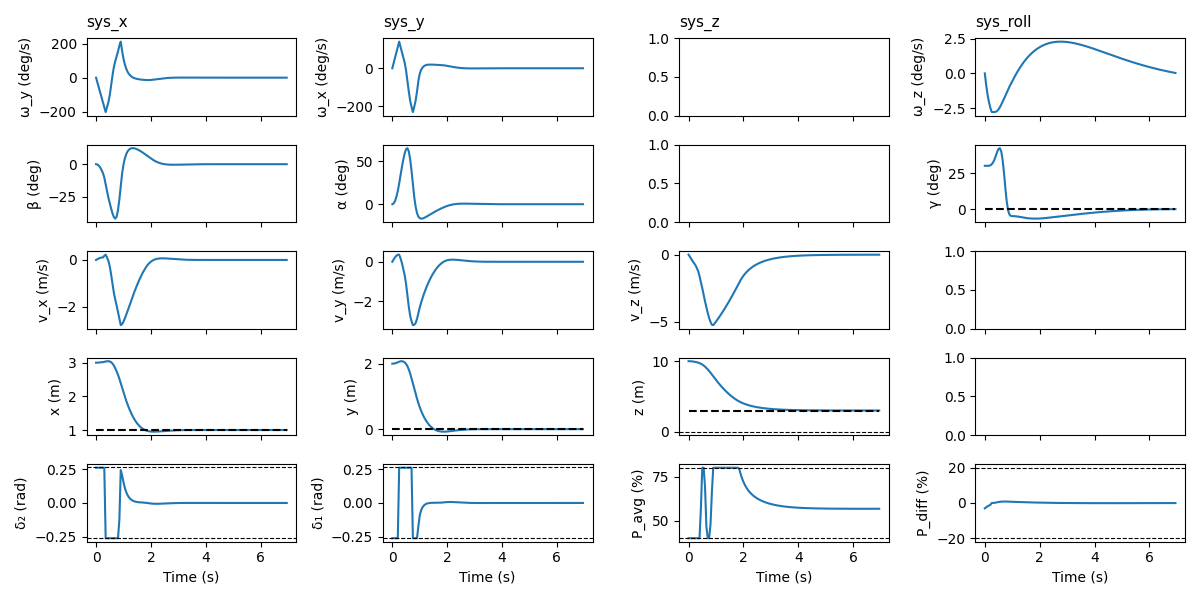

In [7]:
# Open-loop NMPC
print('Open-loop (first horizon)')
plot_static_states_inputs(t_ol0[:-1], x_ol0[:, :-1], u_ol0, xs)

#### 5.2 Closed-loop NMPC

Closed-loop (NMPC)


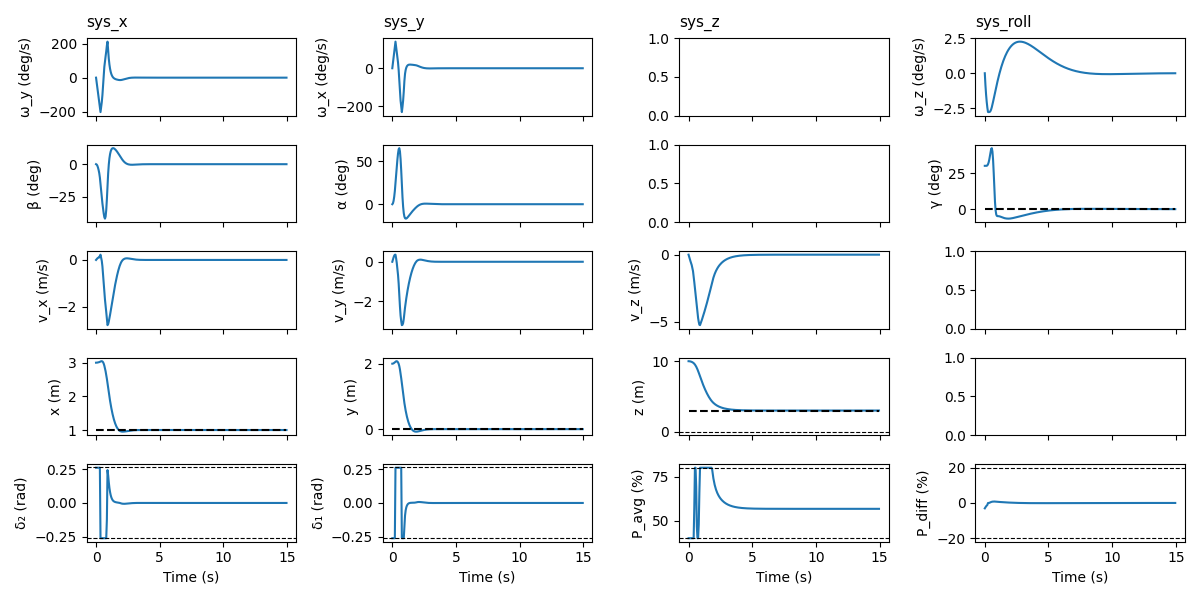

In [8]:
# Closed-loop NMPC
print('Closed-loop (NMPC)')
plot_static_states_inputs(t_cl[:-1], x_cl[:, :-1], u_cl, xs)

#### 5.2 Closed-loop Tube Robust MPC

Closed-loop (Part 6.2 robust+nominal MPC)


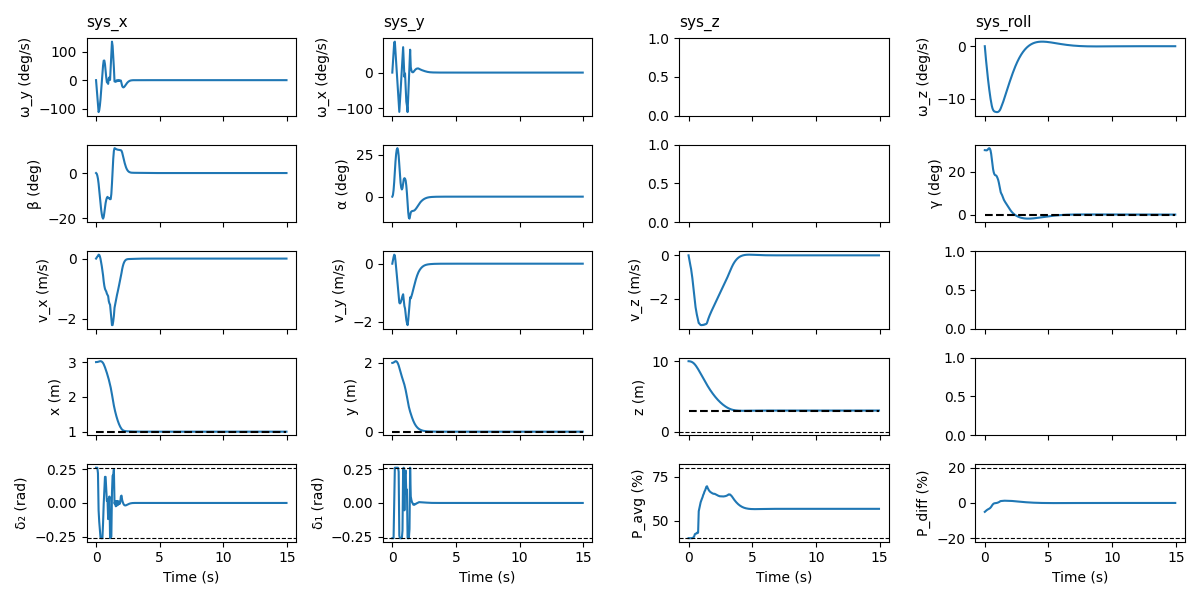

In [9]:
print('Closed-loop (Part 6.2 robust+nominal MPC)')
plot_static_states_inputs(t_cl_lmpc[:-1], x_cl_lmpc[:, :-1], u_cl_lmpc, xs)

## 6. Comparison with linear MPC approaches


Summary plot saved as 'deliverable_7_1_summary.png'


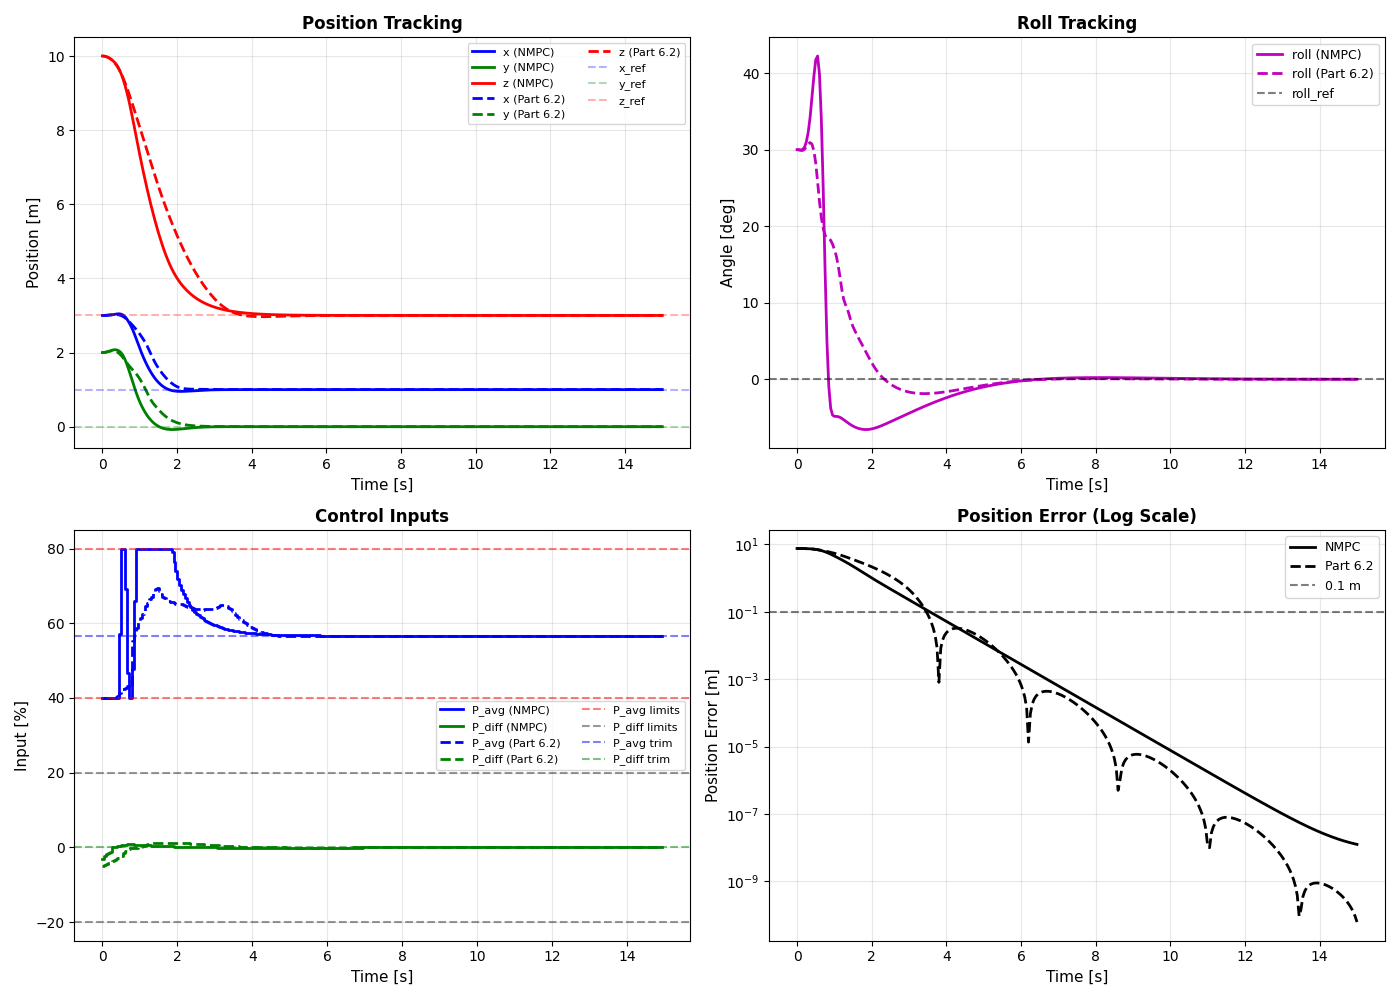

In [10]:
# Summary plot in the same style as Deliverable 6.1
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Positions
ax = axes[0, 0]
ax.plot(t_cl, x_cl[9, :], 'b-', linewidth=2, label='x (NMPC)')
ax.plot(t_cl, x_cl[10, :], 'g-', linewidth=2, label='y (NMPC)')
ax.plot(t_cl, x_cl[11, :], 'r-', linewidth=2, label='z (NMPC)')
ax.plot(t_cl_lmpc, x_cl_lmpc[9, :], 'b--', linewidth=2, label='x (Part 6.2)')
ax.plot(t_cl_lmpc, x_cl_lmpc[10, :], 'g--', linewidth=2, label='y (Part 6.2)')
ax.plot(t_cl_lmpc, x_cl_lmpc[11, :], 'r--', linewidth=2, label='z (Part 6.2)')
ax.axhline(xs[9], color='b', linestyle='--', alpha=0.3, label='x_ref')
ax.axhline(xs[10], color='g', linestyle='--', alpha=0.3, label='y_ref')
ax.axhline(xs[11], color='r', linestyle='--', alpha=0.3, label='z_ref')
ax.set_xlabel('Time [s]', fontsize=11)
ax.set_ylabel('Position [m]', fontsize=11)
ax.set_title('Position Tracking', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8, ncol=2)

# Roll angle (gamma)
ax = axes[0, 1]
ax.plot(t_cl, np.rad2deg(x_cl[5, :]), 'm-', linewidth=2, label='roll (NMPC)')
ax.plot(t_cl_lmpc, np.rad2deg(x_cl_lmpc[5, :]), 'm--', linewidth=2, label='roll (Part 6.2)')
ax.axhline(np.rad2deg(xs[5]), color='k', linestyle='--', alpha=0.5, label='roll_ref')
ax.set_xlabel('Time [s]', fontsize=11)
ax.set_ylabel('Angle [deg]', fontsize=11)
ax.set_title('Roll Tracking', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Inputs
ax = axes[1, 0]
ax.step(t_cl[:-1], u_cl[2, :], 'b-', where='post', linewidth=2, label='P_avg (NMPC)')
ax.step(t_cl[:-1], u_cl[3, :], 'g-', where='post', linewidth=2, label='P_diff (NMPC)')
ax.step(t_cl_lmpc[:-1], u_cl_lmpc[2, :], 'b--', where='post', linewidth=2, label='P_avg (Part 6.2)')
ax.step(t_cl_lmpc[:-1], u_cl_lmpc[3, :], 'g--', where='post', linewidth=2, label='P_diff (Part 6.2)')
ax.axhline(80, color='r', linestyle='--', alpha=0.5, label='P_avg limits')
ax.axhline(40, color='r', linestyle='--', alpha=0.5)
ax.axhline(20, color='k', linestyle='--', alpha=0.4, label='P_diff limits')
ax.axhline(-20, color='k', linestyle='--', alpha=0.4)
ax.axhline(us[2], color='b', linestyle='--', alpha=0.5, label='P_avg trim')
ax.axhline(us[3], color='g', linestyle='--', alpha=0.5, label='P_diff trim')
ax.set_xlabel('Time [s]', fontsize=11)
ax.set_ylabel('Input [%]', fontsize=11)
ax.set_title('Control Inputs', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8, ncol=2)

# Position error norm
ax = axes[1, 1]
pos_err = np.linalg.norm(x_cl[9:12, :] - xs[9:12, None], axis=0)
pos_err_lmpc = np.linalg.norm(x_cl_lmpc[9:12, :] - xs[9:12, None], axis=0)
ax.semilogy(t_cl, pos_err, 'k-', linewidth=2, label='NMPC')
ax.semilogy(t_cl_lmpc, pos_err_lmpc, 'k--', linewidth=2, label='Part 6.2')
ax.axhline(0.1, color='k', linestyle='--', alpha=0.5, label='0.1 m')
ax.set_xlabel('Time [s]', fontsize=11)
ax.set_ylabel('Position Error [m]', fontsize=11)
ax.set_title('Position Error (Log Scale)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, which='both')
ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('deliverable_7_1_summary.png', dpi=300, bbox_inches='tight')
print("\nSummary plot saved as 'deliverable_7_1_summary.png'")
plt.show()